# Lecture 8 Naive Bayes
__MATH 3480__ - Dr. Michael Olson

Reading:
* Geron, 

-----

We should be in the middle of Project 1.
* Discuss the project

-----

We are now going to switch to performing models with `sklearn`. Remember the models that we have discussed in our Machine Learning Landscape:

![Machine Learning Landscape](https://raw.githubusercontent.com/drolsonmi/math3480/main/Notes/Images/3480_05_ML_Landscape.png)

We're going to start with Supervised models (discrete then continuous), then we'll move to unsupervised models (discrete then continuous) and finish with the Large Language Models (LLM).

-----
## Naive Bayes Model
Recall Bayes' Theorem:
$$P(y|X) = \frac{P(y)P(X|y)}{P(X)}$$

In Math 3080, we used the following example:
> A patient is tested for a disease. We want to predict whether this patient has the disease or not using two tests. Each test is ranked as 
> * 0 (not present)
> * 1 (indications it is present but not confirmed)
> * 2 (present)

To predict this, we look at data from past patients.

,Condition 1,Condition 2,Diagnosis
0,0,0,0
1,0,1,0
2,1,2,1
3,0,0,0
4,2,2,1
5,1,1,1
6,0,2,0
7,2,0,1
8,2,1,1
9,1,0,0


/Users/michaelolson/.virtualenvs/ML/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<AxesSubplot:title={'center':'Condition 1 = 2 | Condition 2 = 2'}, xlabel='Diagnosis', ylabel='count'>

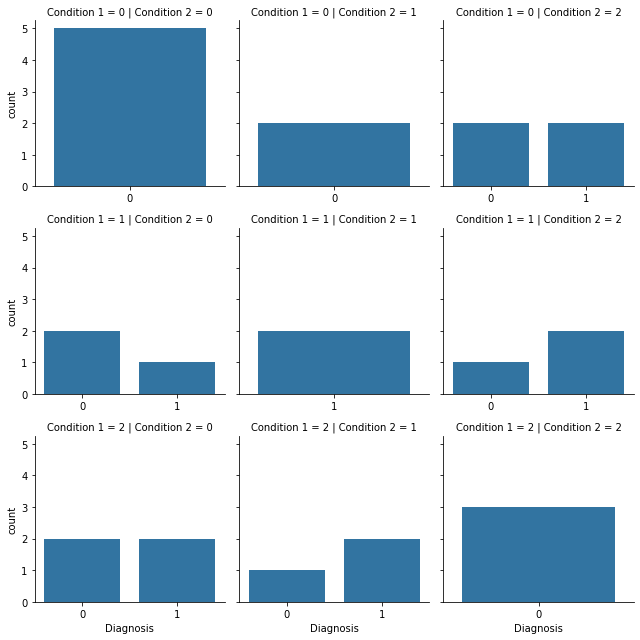

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns

numbers = {
    'Condition 1':[0,0,1,0,2,1,0,2,2,1,0,0,2,2,1,2,0,2,1,0,1,1,2,2,0,0,1,0,2],
    'Condition 2':[0,1,2,0,2,1,2,0,1,0,1,2,0,2,0,1,2,1,2,0,0,1,0,2,0,2,2,0,0],
    'Diagnosis'  :[0,0,1,0,1,1,0,1,1,0,0,1,0,1,1,0,0,1,1,0,0,1,1,1,0,1,0,0,0]
}

numbers = pd.DataFrame(numbers)
display(numbers)

g = sns.FacetGrid(numbers, row='Condition 1', col='Condition 2', sharex=False)
g.map(sns.countplot, 'Diagnosis', dodge=True)
sns.countplot()

## Preprocessing
Before we do any calculations, we have to do the preprocessing
1. Missing Data - No missing values in this example
2. Encode Categorical Variables - No categorical variables
3. Split the data
4. Feature Scaling - Our conditions are already on the same scale, so we can skip this

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(numbers.drop('Diagnosis', axis=1),
                                                    numbers['Diagnosis'],
                                                    test_size=0.15, random_state=22)
display(X_train)
print(y_train.values)

,Condition 1,Condition 2
18,1,2
3,0,0
5,1,1
17,2,1
15,2,1
9,1,0
2,1,2
7,2,0
16,0,2
10,0,1


[1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 1 1 0 0 0 0 1 1]


## Model
Now that we have processed the data, we can calculate the probability of a diagnosis given the conditions using Bayes' Theorem:

In [24]:
num_obs = len(X_train)

num_pos = y_train.sum()
num_neg = len(y_train) - num_pos

print(f"There are {num_pos} positive diagnoses and {num_neg} negative diagnoses")

There are 12 positive diagnoses and 12 negative diagnoses


In [25]:
train_data = X_train.copy()
train_data['Diag'] = y_train
train_data

,Condition 1,Condition 2,Diag
18,1,2,1
3,0,0,0
5,1,1,1
17,2,1,1
15,2,1,0
9,1,0,0
2,1,2,1
7,2,0,1
16,0,2,0
10,0,1,0


Use Bayes' Theorem to find the probability of a positive diagnosis.
$$P(y=1) = \frac{13}{24} \qquad P(X1=2,X2=1|y=1) = \frac{2}{13} \qquad P(X1=2,X2=1)=\frac{3}{24}$$
$$P(y=1|X1=2,X2=1) = \frac{P(y=1)\cdot P(X1=2,X2=1|y=1)}{P(X1=2,X2=1)} = \frac{\tfrac{13}{24}\tfrac{2}{13}}{\tfrac{3}{24}} = \frac{2}{3}$$

Taking its compliment, we get the probability of a negative diagnosis: $P(y=0|X1=1,X2=2) = \frac{1}{3}$

Since the probability is higher for a positive diagnosis, then the patient is given a positive diagnosis.

But now, we have to do that for all possibilities. Here it is:

In [27]:
results = pd.DataFrame(columns=['X1','X2','Positive','Negative'])

index = 0
for x1 in [0,1,2]:
    for x2 in [0,1,2]:
        num = len(train_data[(train_data['Condition 1'] == x1) & (train_data['Condition 2'] == x2)])
        num_cond_pos = len(train_data[(train_data['Condition 1'] == x1) & (train_data['Condition 2'] == x2) & (train_data['Diag'] == 1)])
        num_cond_neg = len(train_data[(train_data['Condition 1'] == x1) & (train_data['Condition 2'] == x2) & (train_data['Diag'] == 0)])
        py_pos = num_pos / num_obs
        py_neg = num_neg / num_obs
        pxy_pos = num_cond_pos / num_pos
        pxy_neg = num_cond_neg / num_neg
        p_cond = num / num_obs
        results.loc[index] = [x1,x2, py_pos*pxy_pos/p_cond, py_neg*pxy_neg/p_cond]
        index += 1
    
display(results)

,X1,X2,Positive,Negative
0,0.0,0.0,0.000000,1.000000
1,0.0,1.0,0.000000,1.000000
2,0.0,2.0,0.333333,0.666667
3,1.0,0.0,0.333333,0.666667
4,1.0,1.0,1.000000,0.000000
5,1.0,2.0,1.000000,0.000000
6,2.0,0.0,0.666667,0.333333
7,2.0,1.0,0.666667,0.333333
8,2.0,2.0,1.000000,0.000000


In [ ]:
# # Not working yet
# results['Prediciton'] = results.apply(lambda x: x['Positive']-x['Negative'])
# display(results)

# Difference ---> Positive if Greater than 0, Negative if Less than 0
results['Prediction'] = results['Positive']-results['Negative']

# Convert to 1 or 0 
  # Divide by absolute value to get +1 or -1,
  # Divide by 2 to get +0.5 or -0.5
  # Add 0.5 to get 1 or 0
  # Turn into an integer
results['Prediction'] = (results['Prediction']/abs(results['Prediction'])/2 + 0.5).apply(int)
results

Now, let's see how to do it in SciKit-Learn.

In [28]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train,y_train)

y_pred = gnb.predict(X_test)

In [29]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[1 2]
 [1 1]]


In [30]:
X_test

,Condition 1,Condition 2
25,0,2
23,2,2
26,1,2
1,0,1
28,2,0


In [31]:
y_test

25    1
23    1
26    0
1     0
28    0
Name: Diagnosis, dtype: int64

In [32]:
y_pred

array([0, 1, 1, 0, 1])